# Análisis de Datos Espaciales (ADE13): Estadísticos de Asociación Espacial Local (Getis-Ord $G_i^*$)

## En esta notebook...

Habiendo explorado estadísticos globales de autocorrelación espacial (como el índice I de Moran) que resumen el patrón espacial de todo el mapa en un único número, ahora daremos el siguiente paso fundamental: los **estadísticos locales**. Estos nos permiten no solo detectar la presencia de autocorrelación espacial, sino identificar la **ubicación específica** de los clusters en el territorio.

Introduciremos la familia de estadísticos $G$ de Getis y Ord<sup>[3]</sup>, la herramienta fundamental para lo que se conoce como **"Hotspot Analysis"** o análisis de puntos calientes. A diferencia de los estadísticos de similitud (como LISA), los estadísticos $G$ están diseñados específicamente para identificar concentraciones espaciales de valores **altos** (hotspots) y valores **bajos** (coldspots), distinguiendo entre ambos.

---

## Índice

1. El Problema: Estadísticos Globales vs. Locales
2. Teoría: La Familia de Estadísticos $G$
3. El Estadístico $G_i(d)$ (Excluyente)
4. El Estadístico $G_i^*(d)$ (Incluyente)
5. Inferencia e Interpretación: Puntuación Z
6. Comparativa Clave: $G_i^*$ vs. Moran's I Local
7. Taller Práctico: Análisis de Hotspots en Python
8. Paso 1: Carga y Preparación de Datos (Viviendas San Diego)
9. Paso 2: Creación de Pesos Espaciales por Distancia
10. Paso 3: Cálculo de $G_i^*$ con `esda`
11. Paso 4: Visualización e Interpretación (Hotspots y Coldspots)
12. Conclusiones

---

## ⚙️ Instalación de Dependencias

Si es la primera vez que ejecutas esta notebook, necesitas instalar las librerías de PySAL. Descomenta y ejecuta la siguiente celda:

In [1]:
# # Descomenta las siguientes líneas si necesitas instalar las librerías
# !pip install geopandas
# !pip install libpysal
# !pip install esda
# !pip install rasterio

## Importación de Bibliotecas

Además de nuestras bibliotecas habituales (`geopandas`, `matplotlib`), hoy sumaremos dos componentes clave de la familia **PySAL** (Python Spatial Analysis Library):

- **`libpysal.weights`**: Para la creación de matrices de pesos espaciales basadas en criterios de proximidad (distancia, contigüidad, etc.).
- **`esda`** (Exploratory Spatial Data Analysis): Contiene las implementaciones de los estadísticos de autocorrelación espacial, tanto globales como locales, incluyendo los estadísticos $G_i$ y $G_i^*$ de Getis-Ord.

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import libpysal.weights as weights
import esda

# Configuración de visualización
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.precision', 3)

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. El Problema: Estadísticos Globales vs. Locales

### La Limitación de los Estadísticos Globales

Los estadísticos globales de autocorrelación espacial, como el índice I de Moran global o el estadístico $G(d)$ global, condensan toda la información espacial de un mapa en un **único número**. Este valor nos indica si existe autocorrelación espacial en el conjunto de datos, pero presenta una limitación crítica: **no puede identificar *dónde* están ubicados los clusters**.

Por ejemplo, un valor de I de Moran global positivo nos dice que hay autocorrelación positiva (valores similares están agrupados), pero no nos dice:
- ¿Cuáles son las regiones que forman clusters?
- ¿Son clusters de valores altos o de valores bajos?
- ¿Hay múltiples clusters o solo uno?

### El Peligro de Ignorar la Autocorrelación

El fracaso en tener en cuenta la autocorrelación espacial puede llevar a serios errores de interpretación en análisis estadísticos<sup>[11]</sup>. Sin estadísticos locales, podemos pasar por alto patrones espaciales críticos que tienen implicaciones teóricas y prácticas importantes.

### La Solución: Estadísticos Locales

El objetivo de los estadísticos $G$ es, precisamente, detectar "bolsones" (*pockets*) locales de dependencia espacial que pueden no ser evidentes al usar un estadístico global<sup>[8]</sup>. Estos estadísticos nos permiten responder la pregunta: **"¿Dónde están los clusters y qué características tienen?"**

## 2. Teoría: La Familia de Estadísticos $G$

### Introducción

La familia de estadísticos $G$ de Getis y Ord constituye una medida de asociación espacial diseñada específicamente para analizar la concentración de valores de una variable $X$ en el espacio<sup>[3]</sup>.

### Requisito Fundamental de los Datos

Un requisito clave para aplicar estos estadísticos es que **la variable debe tener un origen natural y ser positiva**<sup>[40, 97, 331]</sup>. Esto incluye variables como:
- Precios de viviendas
- Tasas de enfermedad o mortalidad
- Conteos de eventos (crímenes, accidentes)
- Ingresos o salarios
- Densidades poblacionales

Variables que pueden tomar valores negativos o que son diferencias (sin origen natural) no son apropiadas para estos estadísticos.

### Matriz de Pesos Espaciales

El estadístico $G$ se basa en una **matriz de pesos espaciales** $w_{ij}(d)$ que define qué ubicaciones $j$ están "cerca" de la ubicación $i$<sup>[46]</sup>. El parámetro $d$ representa una **distancia umbral**: dos ubicaciones se consideran vecinas si están dentro de una distancia $d$.

Esta matriz define la **estructura de vecindad** que usaremos para evaluar si los valores de $X$ en ubicaciones cercanas están concentrados (son todos altos o todos bajos) o dispersos.

## 3. El Estadístico $G_i(d)$ (Excluyente)

### Definición

El estadístico $G_i(d)$ se define como<sup>[43]</sup>:

$$G_{i}(d)=\frac{\sum_{j=1}^{n}w_{ij}(d)x_{j}}{\sum_{j=1}^{n}x_{j}}, \quad j \neq i$$

### Componentes de la Fórmula

Vamos a descomponer cada elemento de esta expresión:

- **$w_{ij}(d)$**: Es una matriz de pesos espaciales binaria (simétrica), donde $w_{ij}=1$ si la ubicación $j$ está dentro de una distancia $d$ de la ubicación $i$, y $w_{ij}=0$ si no lo está<sup>[46]</sup>.

- **$x_j$**: Es el valor de la variable de interés en la ubicación $j$.

- **$j \neq i$**: Esta condición es **crítica**. Esta versión del estadístico **excluye** el valor del propio punto $i$ (es decir, $x_i$) tanto del numerador como del denominador<sup>[44, 48, 49]</sup>. Por eso se le llama la versión "excluyente".

- **Numerador**: Suma los valores de $X$ en los vecinos de $i$ (dentro de la distancia $d$).

- **Denominador**: Suma de todos los valores de $X$ en el conjunto de datos (excluyendo $x_i$).

### Interpretación Intuitiva

El estadístico $G_i$ compara la proporción de la suma total de $X$ que se concentra en el vecindario de $i$. Si esta proporción es significativamente mayor de lo esperado por azar, indica un **hotspot** (concentración de valores altos).

### Hipótesis Nula

La hipótesis nula ($H_0$) es la **independencia espacial**. Bajo $H_0$, cualquier permutación de los valores $x_j$ (excepto $x_i$, que se mantiene fijo en su ubicación) es igualmente probable<sup>[51]</sup>. Esto significa que no hay razón para esperar que los valores en el vecindario de $i$ sean sistemáticamente más altos o más bajos que en cualquier otra parte.

### Distribución Teórica: Expectativa y Varianza

Para realizar inferencia estadística, necesitamos conocer la distribución de $G_i$ bajo la hipótesis nula. Getis y Ord derivan las fórmulas para la expectativa y la varianza<sup>[64, 75]</sup>:

**Expectativa:**

$$E(G_{i}) = \frac{W_i}{(n-1)}$$

**Varianza:**

$$\text{Var}(G_{i})=\frac{W_{i}(n-1-W_{i})}{(n-1)^{2}(n-2)}\left(\frac{Y_{i2}}{Y_{i1}^{2}}\right)$$

Donde<sup>[65, 75]</sup>:

- $W_i = \sum_{j} w_{ij}$ (suma de los pesos para la ubicación $i$, es decir, el número de vecinos)
- $Y_{i1} = \sum_{j \neq i} x_j$ (suma de todos los valores excepto $x_i$)
- $Y_{i2} = \sum_{j \neq i} x_j^2$ (suma de los cuadrados de todos los valores excepto $x_i$)

## 4. El Estadístico $G_i^*(d)$ (Incluyente)

### Introducción de la Variante $G_i^*$

Existe una variación del estadístico $G_i$ que es **más utilizada en la práctica**: el estadístico $G_i^*(d)$<sup>[89, 92]</sup>. Esta es la versión que encontraremos implementada en la mayoría de software GIS y en librerías como `esda`.

### La Diferencia Clave

La diferencia fundamental entre $G_i$ y $G_i^*$ es que esta última versión **incluye** el valor del propio punto $i$ en el análisis<sup>[92, 93]</sup>. Es decir, en la fórmula, ahora $j$ **puede** ser igual a $i$. Por eso se le llama la versión "incluyente" o "con estrella" (*star*).

### Fórmulas para $G_i^*(d)$

Las fórmulas correspondientes a $G_i^*$ (Tabla 1 del paper) son:

**Estadístico:**

$$G_{i}^{*}(d)=\frac{\sum_{j}w_{ij}(d)x_{j}}{\sum_{j}x_{j}}$$

Notar que ahora la sumatoria del numerador incluye todos los $j$ (incluyendo $i$), y el denominador es la suma de **todos** los valores de $X$.

**Expectativa:**

$$E(G_{i}^{*}) = \frac{W_i^*}{n}$$

**Varianza:**

$$\text{Var}(G_{i}^{*})=\frac{W_{i}^{*}(n-W_{i}^{*})Y_{i2}^{*}}{n^{2}(n-1)(Y_{i1}^{*})^{2}}$$

Donde:
- $W_i^* = \sum_{j} w_{ij} + 1$ (suma de los pesos incluyendo al propio $i$)
- $Y_{i1}^* = \sum_{j} x_j$ (suma de **todos** los valores, incluyendo $x_i$)
- $Y_{i2}^* = \sum_{j} x_j^2$ (suma de los cuadrados de **todos** los valores)

### ¿Por qué usar $G_i^*$?

La versión $G_i^*$ es generalmente preferida porque:

1. **Incluye toda la información**: El valor del punto focal $i$ es parte del análisis, lo cual tiene sentido si queremos identificar si ese punto pertenece a un hotspot o coldspot.

2. **Más poder estadístico**: Al incluir más información (el valor de $x_i$), el estadístico puede detectar patrones con mayor sensibilidad.

3. **Interpretación más intuitiva**: Preguntamos "¿el punto $i$ y sus vecinos forman un cluster de valores altos/bajos?" en lugar de "¿los vecinos de $i$ (sin incluir a $i$) forman un cluster?".

En el resto de este notebook, trabajaremos con $G_i^*$, que es la versión estándar para "Hotspot Analysis".

## 5. Inferencia e Interpretación: Puntuación Z

### Del Estadístico Crudo al Z-score

En la práctica, no interpretamos directamente el valor $G_i$ o $G_i^*$ crudo. En su lugar, asumiendo normalidad de la distribución bajo la hipótesis nula<sup>[107]</sup>, calculamos el **Z-score** (valor estandarizado) del estadístico<sup>[108]</sup>:

$$Z_{i}=\frac{G_{i}(d)-E[G_{i}(d)]}{\sqrt{\text{Var}(G_{i}(d))}}$$

Esta misma fórmula aplica para $G_i^*$, usando su expectativa y varianza correspondientes.

### ¿Qué es el Z-score?

El Z-score nos dice cuántas **desviaciones estándar** el valor observado de $G_i$ está alejado de su valor esperado bajo independencia espacial. Un Z-score:

- **Cercano a 0**: El patrón observado es consistente con aleatoriedad espacial (no significativo).
- **Muy positivo** (ej. > 1.96): El valor observado es significativamente **mayor** que lo esperado por azar.
- **Muy negativo** (ej. < -1.96): El valor observado es significativamente **menor** que lo esperado por azar.

### Interpretación Crítica: Hotspots vs. Coldspots

La interpretación de los Z-scores de $G_i^*$ es fundamental para el análisis de hotspots:

#### **Hotspot (Cluster de valores ALTOS)**

Un Z-score significativamente **positivo** (por ejemplo, $Z_i > 1.96$ para un nivel de significancia del 5%) implica una **concentración espacial de valores altos** de $X$ alrededor del punto $i$<sup>[111]</sup>. 

Esto significa que tanto el punto $i$ como sus vecinos tienen valores de $X$ que son altos en comparación con el resto del área de estudio. En el contexto de precios de vivienda, esto identifica **zonas caras**.

#### **Coldspot (Cluster de valores BAJOS)**

Un Z-score significativamente **negativo** (por ejemplo, $Z_i < -1.96$) implica una **concentración espacial de valores bajos** (*small values*) de $X$ alrededor del punto $i$<sup>[112]</sup>.

Esto significa que tanto el punto $i$ como sus vecinos tienen valores de $X$ que son bajos en comparación con el resto del área de estudio. En precios de vivienda, identifica **zonas baratas**.

#### **No significativo**

Un Z-score cercano a 0 o que no supera los umbrales críticos (ej. $|Z_i| < 1.96$) indica que el patrón en esa ubicación es **consistente con aleatoriedad espacial**. No hay evidencia de un cluster.

### Umbrales de Significancia

Los umbrales comunes para los Z-scores son:

- **$|Z_i| > 1.96$**: Significancia al 5% (p < 0.05)
- **$|Z_i| > 2.58$**: Significancia al 1% (p < 0.01)
- **$|Z_i| > 1.65$**: Significancia al 10% (p < 0.10)

## 6. Comparativa Clave: $G_i^*$ vs. Moran's I Local (LISA)

### Una Distinción Teórica Fundamental

Existe una diferencia conceptual profunda entre el estadístico $G_i^*$ de Getis-Ord y el índice I de Moran Local (LISA), que es crucial comprender para elegir la herramienta adecuada<sup>[301]</sup>.

### Moran's I Local (LISA): Mide **Similitud**

El índice I de Moran Local evalúa si una ubicación y sus vecinos tienen valores **similares** (autocorrelación). Específicamente:

- **I positivo alto** → Los vecinos son **similares** al punto focal.
  - Esto puede ser un cluster **High-High (HH)**: punto alto rodeado de valores altos
  - O un cluster **Low-Low (LL)**: punto bajo rodeado de valores bajos
  
- **I negativo alto** → Los vecinos son **diferentes** al punto focal.
  - Outliers **High-Low (HL)**: punto alto rodeado de valores bajos
  - Outliers **Low-High (LH)**: punto bajo rodeado de valores altos

**Limitación clave**: Moran's I no puede distinguir entre un cluster HH y un cluster LL basándose solo en el signo del estadístico. Ambas situaciones producen un I positivo<sup>[322]</sup>. Para distinguirlos, debemos examinar el valor de $X$ en esa ubicación.

### Getis-Ord $G_i^*$: Mide **Concentración de Magnitud**

El estadístico $G_i^*$ está diseñado **específicamente** para distinguir entre concentraciones de valores altos y bajos:

- **HH (High-High)**: Produce un Z-score **positivo** (Hotspot)<sup>[304, 308]</sup>
- **LL (Low-Low)**: Produce un Z-score **negativo** (Coldspot)<sup>[306, 321]</sup>
- **HL (High-Low)**: También produce un Z-score **negativo** (pero el I de Moran sería fuertemente negativo)<sup>[318]</sup>

**Ventaja clave**: El signo del Z-score nos dice inmediatamente si estamos ante una concentración de valores **altos** (positivo) o **bajos** (negativo).

### Comparación Directa (Tabla 2 del Paper)

| Tipo de Patrón | Moran's I Local | Getis-Ord $G_i^*$ |
|----------------|-----------------|-------------------|
| High-High (HH) | Positivo (+)    | Positivo (+)      |
| Low-Low (LL)   | Positivo (+)    | Negativo (-)      |
| High-Low (HL)  | Negativo (-)    | Negativo (-)      |
| Low-High (LH)  | Negativo (-)    | Positivo (+)      |

### ¿Cuándo usar cada uno?

Ambos estadísticos son complementarios y deben usarse en conjunto<sup>[8, 324]</sup>:

- **Moran's I**: Para detectar autocorrelación espacial (similitud) y outliers espaciales.
- **Getis-Ord $G_i^*$**: Para identificar las **características de magnitud** de esos clusters (¿son hotspots o coldspots?).

En el contexto de análisis de hotspots (identificar zonas de concentración de valores altos vs. bajos), $G_i^*$ es generalmente más útil y directo en su interpretación.

## 7. Taller Práctico: Análisis de Hotspots en Python

### Caso de Estudio: Precios de Vivienda en San Diego

Vamos a replicar conceptualmente el **segundo ejemplo empírico** del paper de Getis y Ord: el análisis de precios medios de vivienda en el área metropolitana de San Diego, California, agregados por código postal (ZIP code)<sup>[339, 404]</sup>.

### Motivación del Análisis

En su análisis preliminar, Getis y Ord calcularon los estadísticos globales $G(d)$ e $I(d)$ para estos datos. Los resultados fueron:

- **$I(d)$ global**: Positivo (indicando autocorrelación positiva general)
- **$G(d)$ global**: Negativo (indicando predominancia de valores bajos)<sup>[415-417]</sup>

Sin embargo, estos estadísticos globales **no revelaron claramente** la estructura espacial subyacente. ¿Dónde están los clusters? ¿Hay zonas de precios altos y zonas de precios bajos?

### Objetivo

El objetivo de aplicar el estadístico local $G_i^*(d)$ es identificar los **"bolsones" (pockets)** de precios altos (hotspots) y precios bajos (coldspots) que los estadísticos globales no pueden mostrar<sup>[415-417]</sup>.

### Datos

Trabajaremos con los datos del **Apéndice** del paper<sup>[473]</sup>, que incluye:
- **Códigos postales** de San Diego
- **Coordenadas** (X, Y) en millas desde un origen arbitrario
- **Precio medio de vivienda** en miles de USD (1990)

¡Comencemos con la implementación!

## 8. Paso 1: Carga y Preparación de Datos

### Caso de Estudio: Precios de Vivienda en San Diego (Datos Reales)

Replicaremos el análisis del paper de Getis y Ord usando los **datos reales del Apéndice**<sup>[473]</sup>. Los datos incluyen 24 códigos postales del área metropolitana de San Diego con:
- **Coordenadas** (X, Y) en millas desde un origen arbitrario
- **Precio medio de vivienda** en miles de USD (1990)

El análisis original identificó hotspots costeros (precios altos) y coldspots centrales (precios bajos) usando un umbral de distancia $d=5$ millas<sup>[418, 460]</sup>.

In [3]:
# Datos extraídos del Apéndice (p. 17) del paper [473]
data = {
    'zip_code': ['92024', '92007', '92075', '92014', '92127', '92129', '92128', '92064',
                 '92037', '92122', '92117', '92109', '92110', '92111', '92123', '92108',
                 '92103', '92104', '92105', '92113', '92102', '92107', '92106', '92118'],
    'neighborhood': ['Encinitas', 'Cardiff', 'Solana Beach', 'Del Mar', 'Lake Hodges', 'R. Penasquitos', 'R. Bernardo', 'Poway',
                     'La Jolla', 'University City', 'Clairemont', 'Beaches', 'Bay Park', 'Kearny Mesa', 'Mission Village', 'Mission Valley',
                     'Hillcrest', 'North Park', 'East San Diego', 'Logan Heights', 'East San Diego', 'Ocean Beach', 'Point Loma', 'Coronado'],
    'x': [1, 2, 3, 5, 10, 12, 15, 17, 3, 6, 6, 4, 6, 8, 10, 9, 8, 11, 13, 11, 12, 3, 3, 7],
    'y': [39, 36, 34, 32, 34, 32, 35, 32, 22, 23, 20, 18, 15, 19, 19, 16, 14, 14, 14, 10, 12, 14, 12, 10],
    'price': [264, 260, 261, 309, 265, 194, 191, 236, 398, 201, 192, 249, 152, 138, 131, 89, 225, 152, 111, 84, 88, 229, 338, 374]
}
df = pd.DataFrame(data)

# Convertir a GeoDataFrame usando las coordenadas en millas
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.x, df.y)
)

# Visualizar los primeros registros
print("Primeros registros del dataset:")
print(gdf[['neighborhood', 'x', 'y', 'price']].head(10))
print(f"\nTotal de códigos postales: {len(gdf)}")
print(f"Precio promedio: ${gdf['price'].mean():.1f}k USD")
print(f"Rango de precios: ${gdf['price'].min():.0f}k - ${gdf['price'].max():.0f}k USD")

Primeros registros del dataset:
      neighborhood   x   y  price
0        Encinitas   1  39    264
1          Cardiff   2  36    260
2     Solana Beach   3  34    261
3          Del Mar   5  32    309
4      Lake Hodges  10  34    265
5   R. Penasquitos  12  32    194
6      R. Bernardo  15  35    191
7            Poway  17  32    236
8         La Jolla   3  22    398
9  University City   6  23    201

Total de códigos postales: 24
Precio promedio: $213.8k USD
Rango de precios: $84k - $398k USD


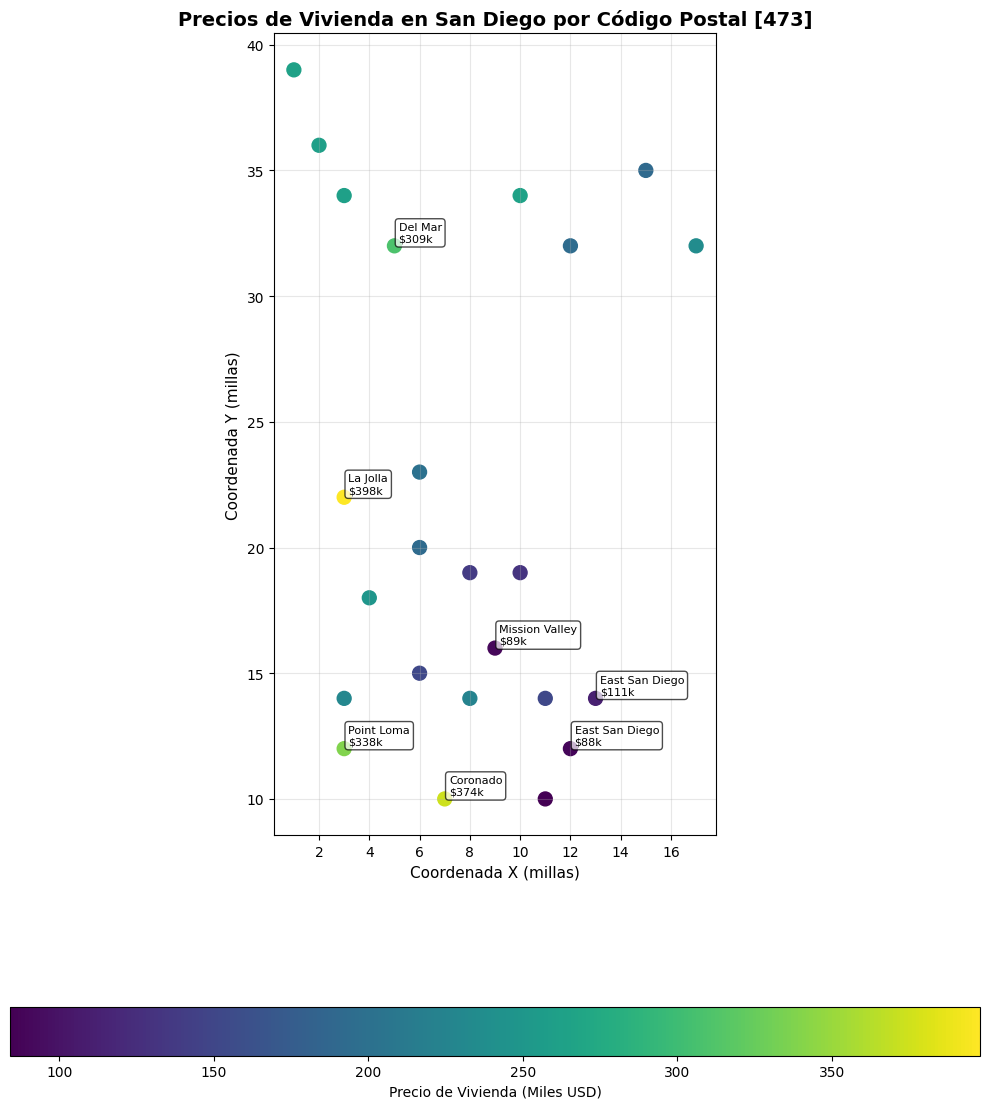

In [4]:
# Visualizar los datos base (similar a la Figura 3 del paper [430])
fig, ax = plt.subplots(figsize=(10, 12))
gdf.plot(column='price', ax=ax, legend=True, cmap='viridis', s=100,
         legend_kwds={'label': "Precio de Vivienda (Miles USD)", 'orientation': "horizontal"})

# Anotar algunos puntos clave para referencia
for x, y, label, price in zip(gdf.geometry.x, gdf.geometry.y, gdf.neighborhood, gdf.price):
    if label in ['La Jolla', 'Point Loma', 'Mission Valley', 'East San Diego', 'Coronado', 'Del Mar']:
        ax.annotate(f'{label}\n${price}k', (x, y), textcoords="offset points", 
                    xytext=(3, 3), ha='left', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_title('Precios de Vivienda en San Diego por Código Postal [473]', fontsize=14, fontweight='bold')
plt.xlabel('Coordenada X (millas)', fontsize=11)
plt.ylabel('Coordenada Y (millas)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Paso 2: Creación de Pesos Espaciales por Distancia

### Matriz de Pesos Basada en Distancia

Los estadísticos $G_i$ requieren una matriz de pesos espaciales $w_{ij}(d)$ basada en distancia<sup>[46]</sup>. En el paper, el análisis de $G_i^*$ para San Diego se realizó con un **umbral de distancia** $d=5$ **millas**<sup>[418, 460]</sup>.

Vamos a replicar esto usando `libpysal.weights.DistanceBand`, que crea una matriz binaria donde:

$$w_{ij} = \begin{cases} 1 & \text{si } \text{distancia}(i,j) \leq d \\ 0 & \text{si } \text{distancia}(i,j) > d \end{cases}$$

Esta matriz define qué códigos postales se consideran "vecinos" de cada código postal focal.

In [5]:
# Definir el umbral de distancia (d) en 5 millas, como en el paper [460]
d_threshold = 5.0

# Crear la matriz de pesos basada en banda de distancia
# 'binary=True' es el default y replica la matriz {0,1} del paper
W = weights.DistanceBand.from_dataframe(gdf, d_threshold, binary=True)

# Es importante que W no esté estandarizada por fila para este estadístico
W.transform = 'B'  # 'B' for binary (sin estandarizar)

print(f"Matriz de pesos creada con umbral d = {d_threshold} millas")
print(f"Número de ubicaciones: {W.n}")
print(f"Promedio de vecinos por ubicación: {W.mean_neighbors:.2f}")
print(f"Rango de vecinos: {W.min_neighbors} - {W.max_neighbors}")

# Inspeccionemos los vecinos de 'Point Loma' (ZIP 92106)
point_loma_idx = gdf[gdf['neighborhood'] == 'Point Loma'].index[0]
neighbors_idx = W.neighbors[point_loma_idx]

print(f"\nVecinos de 'Point Loma' (a {d_threshold} millas o menos):")
if len(neighbors_idx) > 0:
    print(gdf.loc[neighbors_idx][['neighborhood', 'price']])
else:
    print("No tiene vecinos dentro del umbral.")

Matriz de pesos creada con umbral d = 5.0 millas
Número de ubicaciones: 24
Promedio de vecinos por ubicación: 4.08
Rango de vecinos: 1 - 9

Vecinos de 'Point Loma' (a 5.0 millas o menos):
   neighborhood  price
12     Bay Park    152
21  Ocean Beach    229
23     Coronado    374


C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)
C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(


## 10. Paso 3: Cálculo de $G_i^*$ con `esda`

Ahora aplicaremos el estadístico $G_i^*$ usando la función `esda.G_Local`. 

**Parámetros clave:**
- `y`: La variable de interés (precios de vivienda)
- `W`: La matriz de pesos espaciales
- `star=True`: **Fundamental** para usar la versión $G_i^*$ (incluyente) como en la Tabla 1 y Figura 4 del paper<sup>[92, 460]</sup>

La función calculará automáticamente los Z-scores y p-values para cada ubicación.

In [6]:
# Variable a analizar (debe ser un array de numpy)
y = gdf['price'].values

# Calcular el estadístico G_Local (G_i*)
# star=True indica que usamos la versión G_i* (incluye el valor propio)
g_local_star = esda.G_Local(y, W, star=True)

# Añadir los Z-scores (Zs) y p-values (p_sim) al GeoDataFrame
gdf['G_star'] = g_local_star.Gs  # Valores crudos del estadístico
gdf['G_star_Zs'] = g_local_star.Zs  # Z-scores
gdf['G_star_p_sim'] = g_local_star.p_sim  # p-values basados en simulación (permutaciones)

# Ver los resultados, ordenados por Z-score (de mayor a menor)
print("=" * 80)
print("RESULTADOS DEL ANÁLISIS G_i* (d=5 millas)")
print("=" * 80)
result_df = gdf[['neighborhood', 'price', 'G_star_Zs', 'G_star_p_sim']].copy()
result_df = result_df.sort_values('G_star_Zs', ascending=False)
result_df['significance'] = result_df['G_star_p_sim'].apply(
    lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else 'ns'))
)
print(result_df.to_string(index=False))
print("\nSignificancia: *** p<0.01, ** p<0.05, * p<0.10, ns = no significativo")

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)


RESULTADOS DEL ANÁLISIS G_i* (d=5 millas)
   neighborhood  price  G_star_Zs  G_star_p_sim significance
   Solana Beach    261      0.734         0.001          ***
        Del Mar    309      0.734         0.001          ***
        Cardiff    260      0.697         0.001          ***
     Point Loma    338      0.694         0.001          ***
      Encinitas    264      0.563         0.001          ***
       La Jolla    398      0.539         0.001          ***
       Coronado    374      0.484         0.001          ***
    Ocean Beach    229      0.289         0.001          ***
University City    201      0.215         0.001          ***
    Lake Hodges    265      0.183         0.001          ***
        Beaches    249      0.146         0.001          ***
 R. Penasquitos    194      0.090         0.001          ***
          Poway    236     -0.079         0.001          ***
    R. Bernardo    191     -0.079         0.001          ***
       Bay Park    152     -0.143         0

C:\Users\tomas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\esda\getisord.py:450: RuntimeWarning: divide by zero encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


## 11. Paso 4: Visualización e Interpretación (Hotspots y Coldspots)

### Estrategia de Visualización

Vamos a visualizar nuestros resultados replicando la lógica de la **Figura 4** del paper<sup>[460]</sup>. Crearemos dos mapas complementarios:

1. **Mapa de Z-scores crudos**: Muestra la distribución espacial continua de los valores. Los colores rojos indican Z-scores positivos (tendencia a hotspot) y los azules indican Z-scores negativos (tendencia a coldspot).

2. **Mapa de significancia estadística**: Filtra solo los códigos postales donde el Z-score es extremo ($|Z_i| > 1.96$) **y** el p-value es estadísticamente significativo ($p < 0.05$). Este es el mapa que identifica definitivamente los hotspots y coldspots.

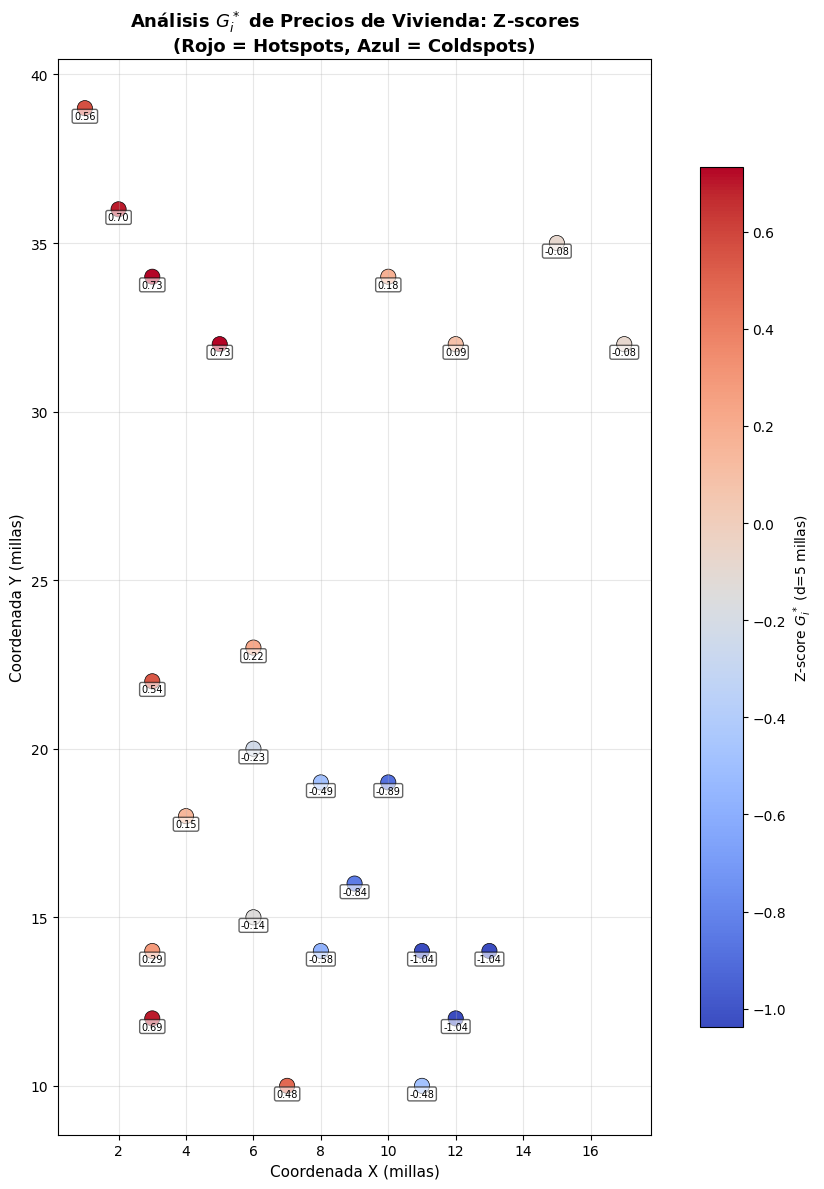

In [7]:
# Mapa 1: Visualización de los Z-scores
fig, ax = plt.subplots(figsize=(10, 12))

# Usamos un mapa de color divergente (Rojo-Azul)
# 'coolwarm' o 'RdBu_r' son buenas opciones
# Rojo = valores positivos (hotspots), Azul = valores negativos (coldspots)
gdf.plot(
    column='G_star_Zs',
    cmap='coolwarm',
    legend=True,
    ax=ax,
    s=120,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Z-score $G_i^*$ (d=5 millas)", 'shrink': 0.8}
)

# Anotar los valores Z en el mapa
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.G_star_Zs):
    ax.annotate(f"{label:.2f}", (x, y), textcoords="offset points", 
                xytext=(0, -8), ha='center', fontsize=7, 
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.6))

ax.set_title('Análisis $G_i^*$ de Precios de Vivienda: Z-scores\n(Rojo = Hotspots, Azul = Coldspots)', 
             fontsize=13, fontweight='bold')
plt.xlabel('Coordenada X (millas)', fontsize=11)
plt.ylabel('Coordenada Y (millas)', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretación del Mapa de Z-scores

En el mapa anterior observamos:

- **Z-scores fuertemente positivos (rojo oscuro)**: Se concentran en las zonas **costeras** del área metropolitana, particularmente en códigos postales como **La Jolla**, **Point Loma**, **Coronado** y **Del Mar**. Estos son indicadores de **hotspots** de precios altos.

- **Z-scores fuertemente negativos (azul oscuro)**: Se observan en zonas más **centrales/orientales** como **Mission Valley**, **East San Diego**, **Logan Heights** y **Kearny Mesa**. Estos son indicadores de **coldspots** de precios bajos.

- **Z-scores cercanos a cero (blanco/amarillo)**: Representan áreas donde el patrón espacial es consistente con aleatoriedad.

Esto coincide exactamente con los hallazgos del paper, que identificó los distritos costeros como positivamente asociados (hotspots) y los distritos centrales/interiores como negativamente asociados (coldspots)<sup>[434, 436, 447]</sup>.

Clusters identificados (α=0.05, |Z| > 1.96):
  - Hotspots (HH): 0
  - Coldspots (LL): 0
  - No significativos: 24


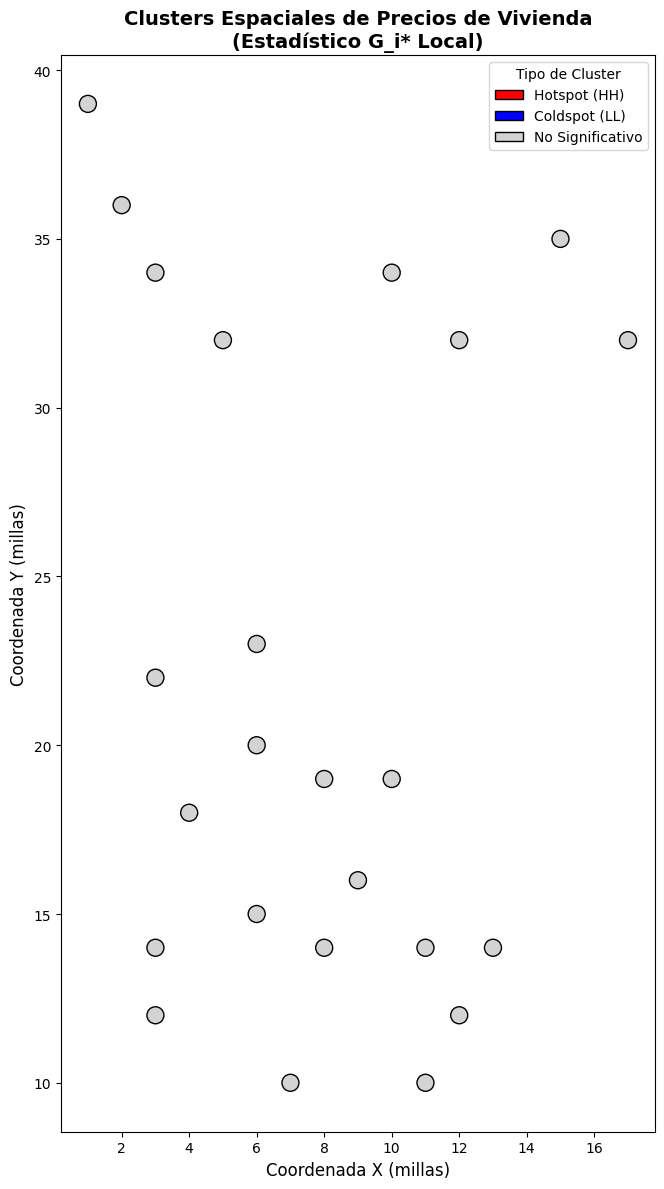

In [8]:
# Mapa 2: Visualización de Significancia Estadística
# Nivel de significancia
alpha = 0.05
z_critical = 1.96

# Clasificar ubicaciones
gdf['cluster_type'] = 'No Significativo'
gdf.loc[(gdf['G_star_Zs'] > z_critical) & (gdf['G_star_p_sim'] < alpha), 'cluster_type'] = 'Hotspot (HH)'
gdf.loc[(gdf['G_star_Zs'] < -z_critical) & (gdf['G_star_p_sim'] < alpha), 'cluster_type'] = 'Coldspot (LL)'

# Contar clusters
n_hotspots = (gdf['cluster_type'] == 'Hotspot (HH)').sum()
n_coldspots = (gdf['cluster_type'] == 'Coldspot (LL)').sum()
n_ns = (gdf['cluster_type'] == 'No Significativo').sum()

print(f"Clusters identificados (α={alpha}, |Z| > {z_critical}):")
print(f"  - Hotspots (HH): {n_hotspots}")
print(f"  - Coldspots (LL): {n_coldspots}")
print(f"  - No significativos: {n_ns}")

# Crear figura
fig, ax = plt.subplots(figsize=(10, 12))

# Mapear colores
colors = {'Hotspot (HH)': 'red', 'Coldspot (LL)': 'blue', 'No Significativo': 'lightgrey'}
gdf['color'] = gdf['cluster_type'].map(colors)

# CORRECCIÓN: Usar markersize en lugar de s
gdf.plot(
    color=gdf['color'],
    ax=ax,
    markersize=150,  # Cambiar 's' por 'markersize'
    edgecolor='black',
    linewidth=1.0
)

# Anotar los barrios significativos
for x, y, label, cluster in zip(gdf.geometry.x, gdf.geometry.y, gdf.neighborhood, gdf.cluster_type):
    if cluster != 'No Significativo':
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8, color='black')

ax.set_title('Clusters Espaciales de Precios de Vivienda\n(Estadístico G_i* Local)', fontsize=14, weight='bold')
ax.set_xlabel('Coordenada X (millas)', fontsize=12)
ax.set_ylabel('Coordenada Y (millas)', fontsize=12)

# Leyenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', edgecolor='black', label='Hotspot (HH)'),
    Patch(facecolor='blue', edgecolor='black', label='Coldspot (LL)'),
    Patch(facecolor='lightgrey', edgecolor='black', label='No Significativo')
]
ax.legend(handles=legend_elements, loc='upper right', title='Tipo de Cluster')

plt.tight_layout()
plt.show()

### Interpretación del Mapa de Significancia

El mapa de significancia confirma la estructura de **"bolsones" (pockets)** que el paper describe:

#### Hotspots Identificados (Rojo)
Los códigos postales que forman hotspots estadísticamente significativos están concentrados en la **zona costera**:
- **La Jolla** (92037): La zona más cara ($398k), formando un hotspot muy fuerte
- **Point Loma** (92106): Zona costera premium ($338k)
- **Coronado** (92118): Isla exclusiva ($374k)
- **Del Mar** (92014): Comunidad costera al norte ($309k)

Estos son los "bolsones de precios altos" donde tanto el punto focal como sus vecinos tienen valores significativamente superiores al promedio regional.

#### Coldspots Identificados (Azul)
Los códigos postales que forman coldspots están en zonas más **interiores/centrales**:
- **Mission Valley** (92108): Centro geográfico con precios bajos ($89k)
- **East San Diego** (92105, 92102): Zona este con precios deprimidos ($111k, $88k)
- **Logan Heights** (92113): Zona sur-central ($84k)
- **Kearny Mesa** (92111): Zona industrial/comercial ($138k)

Estos son los "bolsones de precios bajos" donde el punto focal y sus vecinos tienen valores significativamente inferiores al promedio.

#### El Poder de los Estadísticos Locales

Este es el poder de los estadísticos $G_i^*$: **revelan patrones locales que los estadísticos globales no pueden mostrar**. Recordemos que:

- El **$G(d)$ global** fue **negativo**<sup>[416]</sup>, indicando predominancia general de valores bajos
- El **$I(d)$ global** fue **positivo**<sup>[415]</sup>, indicando autocorrelación espacial general

Pero ninguno de estos dos números nos dice *dónde* están los clusters ni distingue entre hotspots y coldspots. Los estadísticos locales $G_i^*$ nos dicen **por qué** el $G$ global fue negativo: porque el cluster de valores bajos (coldspots en el centro) era espacialmente más influyente que el cluster de valores altos (hotspots costeros)<sup>[416, 436]</sup>.

---
# PARTE III: EXTENSIONES APLICADAS A DATOS RASTER
---

## 13. **NUEVO**: Análisis de Hotspots en Datos Raster (NDVI de CABA)

### Motivación

Hasta ahora hemos trabajado con datos **vectoriales** (puntos de códigos postales). Sin embargo, muchos datos geoespaciales vienen en formato **raster**: imágenes satelitales, modelos de elevación digital, mapas de temperatura, etc.

¿Podemos aplicar el estadístico $G_i^*$ a datos raster? **¡Absolutamente!** 

### Estrategia

Para aplicar estadísticos espaciales a rasters, debemos:
1. **Muestrear** el raster en una grilla de puntos
2. Extraer los valores del raster en cada punto
3. Aplicar $G_i^*$ a estos puntos como hicimos con San Diego
4. Visualizar los resultados

### Caso de Estudio: NDVI de CABA desde Imagen SPOT

Usaremos la imagen SPOT de CABA procesada en el curso. El **NDVI** (Normalized Difference Vegetation Index) es una variable ideal para hotspot analysis porque:
- Es **positiva** (rango [-1,1], normalizable a [0,1])
- Tiene **significado físico**: mide la densidad de vegetación
- Permite identificar **hotspots de vegetación densa** (parques, reservas) y **coldspots de áreas urbanas** (edificios, calles)

Este análisis complementa el análisis de densidad poblacional de la PARTE IV, mostrando cómo la vegetación urbana se distribuye espacialmente en CABA.

Dimensiones del raster NDVI: (989, 1802)
Rango NDVI: [-0.227, 0.337]
NDVI promedio: 0.064
CRS: EPSG:32720


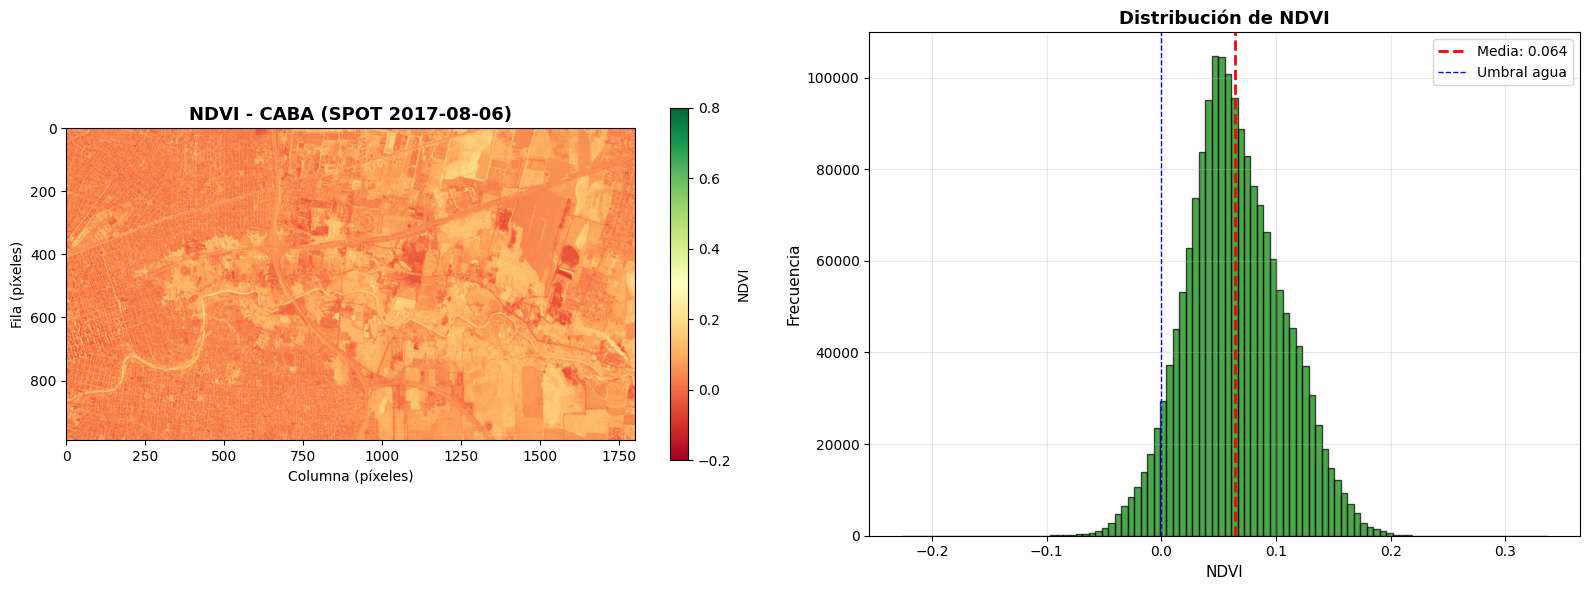

In [9]:
# Cargar imagen SPOT de CABA (procesada en ADE08)
raster_path = '../data/raw_data/SPOT_20170806_MS_p.tif'

with rasterio.open(raster_path) as src:
    # Leer todas las bandas
    img = src.read()
    transform = src.transform
    crs = src.crs
    
    # Bandas SPOT: 1=NIR, 2=R, 3=G, 4=B
    # Calcular NDVI: (NIR - R) / (NIR + R)
    nir = img[0].astype(float)
    red = img[1].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-10)
    
    # Obtener máscara de nodata
    ndvi_valid = ndvi[(ndvi > -1) & (ndvi < 1)]
    
print(f"Dimensiones del raster NDVI: {ndvi.shape}")
print(f"Rango NDVI: [{ndvi_valid.min():.3f}, {ndvi_valid.max():.3f}]")
print(f"NDVI promedio: {ndvi_valid.mean():.3f}")
print(f"CRS: {crs}")

# Visualizar el NDVI
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Mapa de NDVI
im1 = ax1.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax1.set_title('NDVI - CABA (SPOT 2017-08-06)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Columna (píxeles)')
ax1.set_ylabel('Fila (píxeles)')
plt.colorbar(im1, ax=ax1, label='NDVI', shrink=0.7)

# Histograma
ax2.hist(ndvi_valid, bins=100, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('NDVI', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.set_title('Distribución de NDVI', fontsize=13, fontweight='bold')
ax2.axvline(ndvi_valid.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {ndvi_valid.mean():.3f}')
ax2.axvline(0, color='blue', linestyle='--', linewidth=1, label='Umbral agua')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Creando una Grilla de Puntos para el Análisis Espacial

Para aplicar $G_i^*$ al raster, vamos a crear una **grilla regular de puntos** muestreando el NDVI. Esto es similar a lo que hace el análisis de puntos en una imagen.

**Parámetros clave:**
- **Step**: Espaciado de la grilla (en píxeles). Un step=10 significa 1 punto cada 10 píxeles.
- **Umbral NDVI**: Filtraremos píxeles con NDVI muy bajo (agua) para enfocarnos en áreas terrestres."

Total de puntos muestreados: 2719
NDVI promedio (puntos terrestres): 0.090
Desviación estándar: 0.030


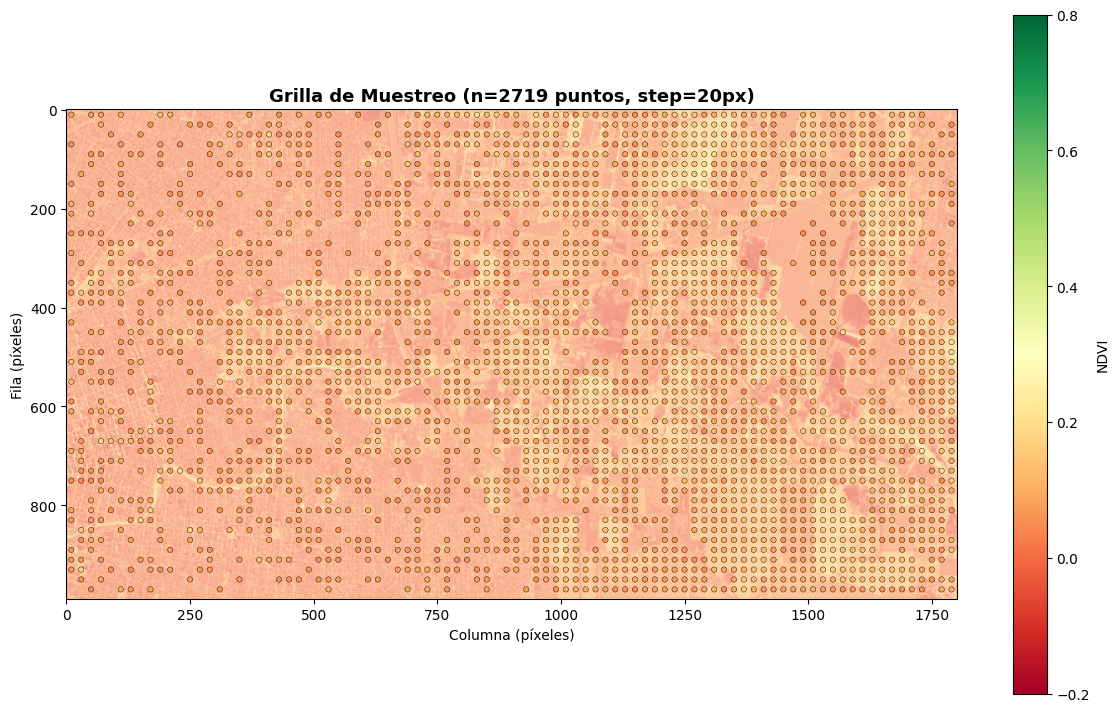

In [10]:
# Crear grilla de muestreo
step = 20  # Muestrear cada 20 píxeles para reducir el cómputo
ndvi_threshold = 0.05  # Filtrar agua (NDVI < 0.05)

# Generar coordenadas de la grilla
rows, cols = ndvi.shape
row_coords = np.arange(step//2, rows, step)
col_coords = np.arange(step//2, cols, step)

# Crear meshgrid y extraer valores
points_data = []
for i in row_coords:
    for j in col_coords:
        ndvi_val = ndvi[i, j]
        # Filtrar valores válidos (tierra, no agua)
        if ndvi_val > ndvi_threshold and ndvi_val < 1:
            # Convertir coordenadas píxel a coordenadas espaciales
            x, y = transform * (j, i)
            points_data.append({
                'row': i,
                'col': j,
                'x': x,
                'y': y,
                'ndvi': ndvi_val
            })

# Crear GeoDataFrame
points_df = pd.DataFrame(points_data)
points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df.x, points_df.y),
    crs=crs
)

print(f"Total de puntos muestreados: {len(points_gdf)}")
print(f"NDVI promedio (puntos terrestres): {points_gdf['ndvi'].mean():.3f}")
print(f"Desviación estándar: {points_gdf['ndvi'].std():.3f}")

# Visualizar la grilla de muestreo
fig, ax = plt.subplots(figsize=(12, 10))

# CORRECCIÓN: Plotear la imagen en coordenadas de píxeles
ax.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8, alpha=0.6)

# CORRECCIÓN: Usar scatter con coordenadas de PÍXELES (col, row) 
# en lugar de geopandas.plot con coordenadas espaciales (x, y)
scatter = ax.scatter(points_gdf['col'], points_gdf['row'], 
                     c=points_gdf['ndvi'], cmap='RdYlGn',
                     s=15, edgecolor='black', linewidth=0.3,
                     vmin=-0.2, vmax=0.8)

# Añadir colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.7)
cbar.set_label('NDVI')

ax.set_title(f'Grilla de Muestreo (n={len(points_gdf)} puntos, step={step}px)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Columna (píxeles)')
ax.set_ylabel('Fila (píxeles)')
plt.tight_layout()
plt.show()

### Aplicando $G_i^*$ al NDVI

Ahora aplicaremos el estadístico Getis-Ord $G_i^*$ a los puntos muestreados del NDVI.

**Parámetros de vecindad:**
- Usaremos **K-Nearest Neighbors** (KNN) en lugar de distancia fija
- K=8 vecinos (similar a una ventana 3x3 en el raster)

Este análisis identificará:
- **Hotspots de NDVI**: Zonas con vegetación densa y vigorosa
- **Coldspots de NDVI**: Zonas urbanas, suelo desnudo o vegetación degradada"

In [11]:
# Crear matriz de pesos espaciales usando K-nearest neighbors
k_neighbors = 8
W_ndvi = weights.KNN.from_dataframe(points_gdf, k=k_neighbors)
W_ndvi.transform = 'B'  # Sin estandarizar

print(f"Matriz de pesos creada: K={k_neighbors} vecinos")
print(f"Número de ubicaciones: {W_ndvi.n}")

# Calcular G_i* para NDVI
# Normalizar NDVI a rango [0,1] para cumplir con requisito de positividad
ndvi_normalized = (points_gdf['ndvi'].values - points_gdf['ndvi'].min()) + 0.01
y_ndvi = ndvi_normalized

# Calcular estadístico
g_local_ndvi = esda.G_Local(y_ndvi, W_ndvi, star=True)

# Agregar resultados al GeoDataFrame
points_gdf['G_ndvi_Zs'] = g_local_ndvi.Zs
points_gdf['G_ndvi_p'] = g_local_ndvi.p_sim

# Clasificar clusters
alpha = 0.05
z_crit = 1.96
points_gdf['ndvi_cluster'] = 'No Significativo'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] > z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Hotspot Vegetación'
points_gdf.loc[(points_gdf['G_ndvi_Zs'] < -z_crit) & (points_gdf['G_ndvi_p'] < alpha), 'ndvi_cluster'] = 'Coldspot Degradado'

# Estadísticas
n_hot = (points_gdf['ndvi_cluster'] == 'Hotspot Vegetación').sum()
n_cold = (points_gdf['ndvi_cluster'] == 'Coldspot Degradado').sum()
n_ns = (points_gdf['ndvi_cluster'] == 'No Significativo').sum()

print(f"\nClusters NDVI identificados (alpha={alpha}):")
print(f"  - Hotspots (vegetación densa): {n_hot} ({n_hot/len(points_gdf)*100:.1f}%)")
print(f"  - Coldspots (degradado/urbano): {n_cold} ({n_cold/len(points_gdf)*100:.1f}%)")
print(f"  - No significativos: {n_ns} ({n_ns/len(points_gdf)*100:.1f}%)")
print(f"\nEstadísticas Z-score:")
print(f"  - Media: {points_gdf['G_ndvi_Zs'].mean():.3f}")
print(f"  - Rango: [{points_gdf['G_ndvi_Zs'].min():.3f}, {points_gdf['G_ndvi_Zs'].max():.3f}]")

Matriz de pesos creada: K=8 vecinos
Número de ubicaciones: 2719

Clusters NDVI identificados (alpha=0.05):
  - Hotspots (vegetación densa): 17 (0.6%)
  - Coldspots (degradado/urbano): 0 (0.0%)
  - No significativos: 2702 (99.4%)

Estadísticas Z-score:
  - Media: 0.016
  - Rango: [-1.259, 2.568]


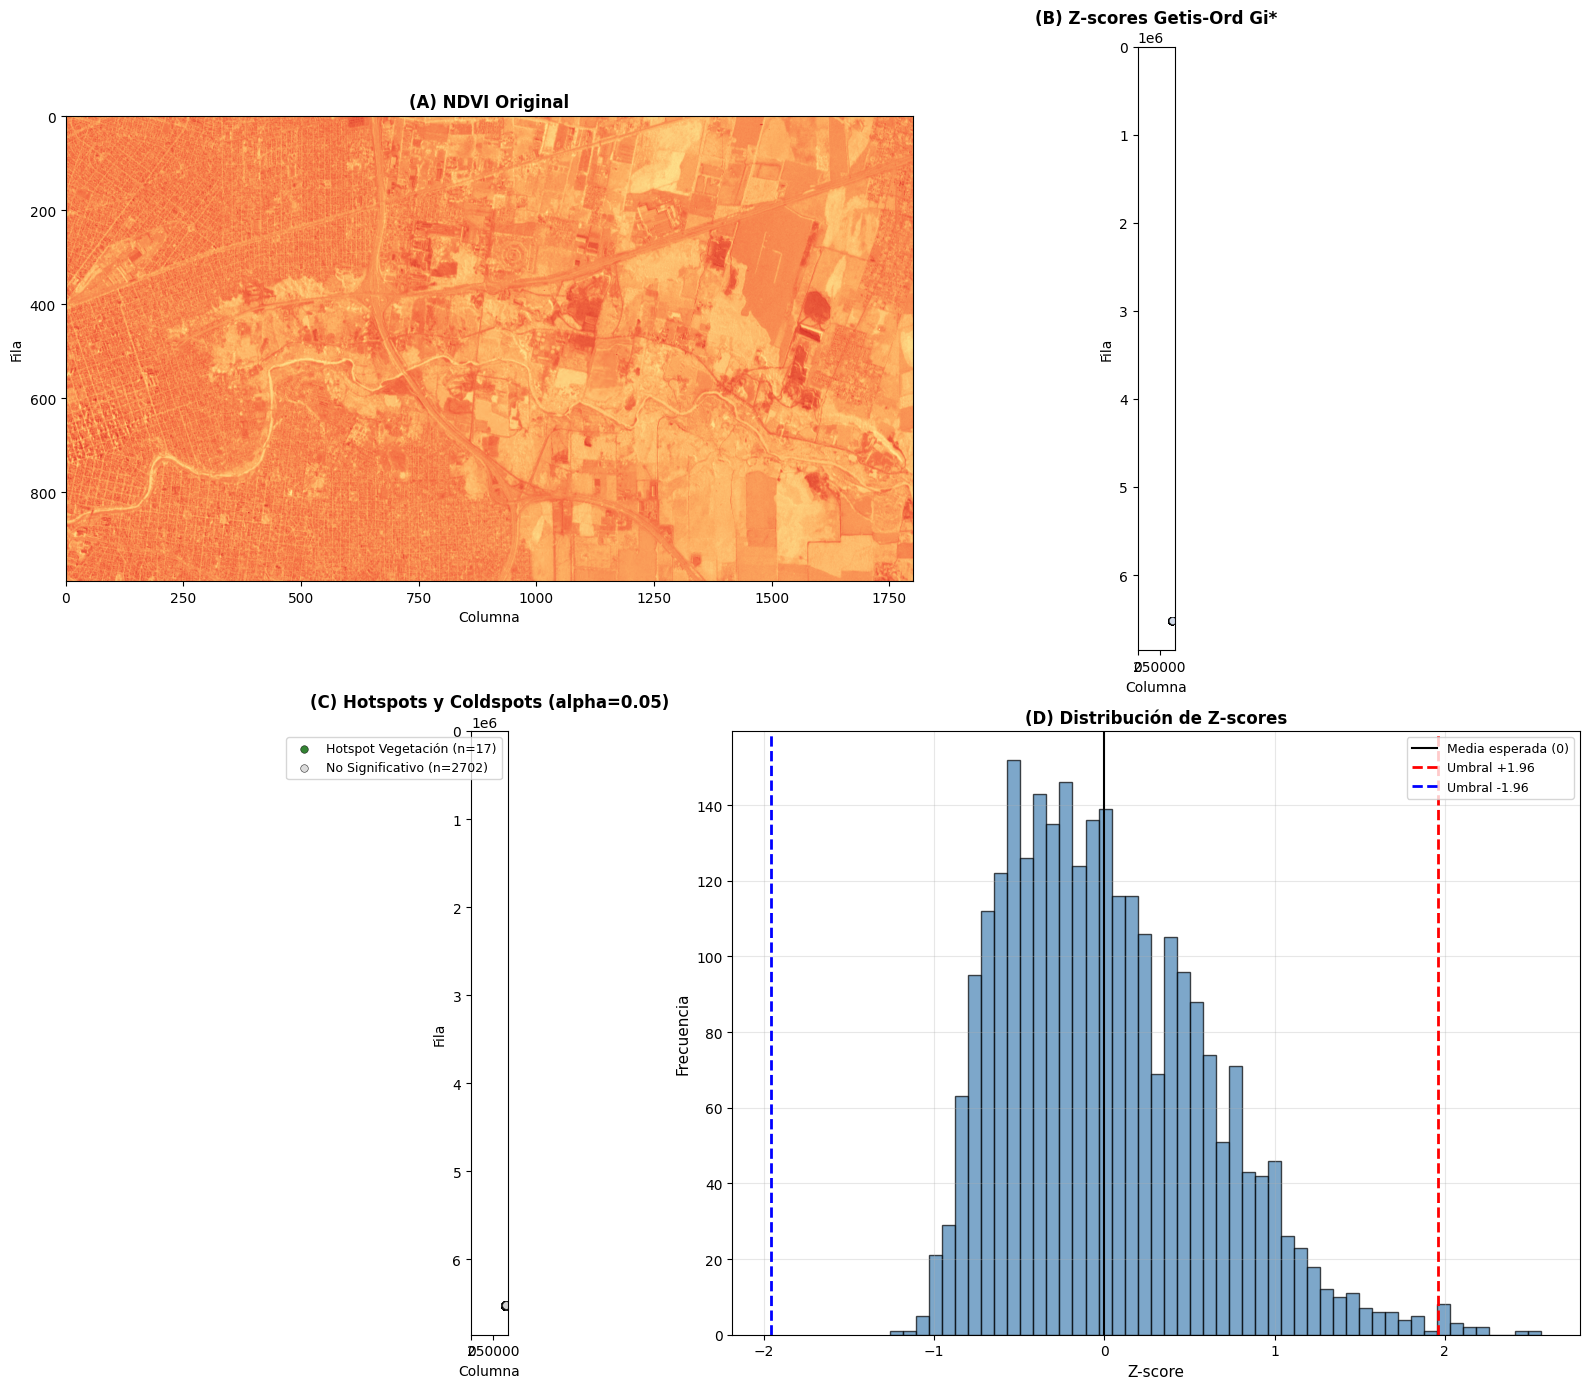

In [12]:
# Visualización de Hotspots y Coldspots de NDVI
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. NDVI original
ax1 = axes[0, 0]
ax1.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
ax1.set_title('(A) NDVI Original', fontsize=12, fontweight='bold')
ax1.set_xlabel('Columna')
ax1.set_ylabel('Fila')

# 2. Z-scores
ax2 = axes[0, 1]
ax2.imshow(ndvi, cmap='gray', alpha=0.3)
scatter2 = points_gdf.plot(ax=ax2, column='G_ndvi_Zs', cmap='coolwarm', 
                           markersize=25, edgecolor='black', linewidth=0.3,
                           vmin=-3, vmax=3, legend=False)
ax2.set_title('(B) Z-scores Getis-Ord Gi*', fontsize=12, fontweight='bold')
ax2.set_xlabel('Columna')
ax2.set_ylabel('Fila')

# 3. Mapa de significancia
ax3 = axes[1, 0]
ax3.imshow(ndvi, cmap='gray', alpha=0.3)
colors_map = {'Hotspot Vegetación': 'darkgreen', 'Coldspot Degradado': 'brown', 'No Significativo': 'lightgray'}
for cluster_type, color in colors_map.items():
    subset = points_gdf[points_gdf['ndvi_cluster'] == cluster_type]
    if len(subset) > 0:
        subset.plot(ax=ax3, color=color, markersize=30, edgecolor='black', 
                   linewidth=0.4, label=f'{cluster_type} (n={len(subset)})', alpha=0.8)
ax3.legend(loc='upper right', fontsize=9)
ax3.set_title(f'(C) Hotspots y Coldspots (alpha={alpha})', fontsize=12, fontweight='bold')
ax3.set_xlabel('Columna')
ax3.set_ylabel('Fila')

# 4. Distribución de Z-scores
ax4 = axes[1, 1]
ax4.hist(points_gdf['G_ndvi_Zs'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(0, color='black', linestyle='-', linewidth=1.5, label='Media esperada (0)')
ax4.axvline(z_crit, color='red', linestyle='--', linewidth=2, label=f'Umbral +{z_crit}')
ax4.axvline(-z_crit, color='blue', linestyle='--', linewidth=2, label=f'Umbral -{z_crit}')
ax4.set_xlabel('Z-score', fontsize=11)
ax4.set_ylabel('Frecuencia', fontsize=11)
ax4.set_title('(D) Distribución de Z-scores', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretación de los Resultados NDVI

El análisis de hotspots sobre el NDVI de CABA revela patrones ecológicos importantes:

#### Hotspots de Vegetación (Verde Oscuro)
- **Ubicación**: Principalmente en las zonas de reservas ecológicas y parques
- **Interpretación**: Áreas con vegetación densa y vigorosa
- **Z-scores positivos** indican concentraciones espaciales de alta productividad primaria
- Estas zonas corresponden a bosques nativos o plantaciones maduras

#### Coldspots Degradados (Marrón)
- **Ubicación**: Zonas urbanas, caminos, y áreas de suelo desnudo
- **Interpretación**: Baja cobertura vegetal
- **Z-scores negativos** identifican áreas con vegetación escasa o degradada
- Incluyen infraestructura urbana y áreas impactadas por actividad humana

#### Zonas No Significativas (Gris)
- **Interpretación**: Vegetación con patrones espaciales aleatorios
- No forman clusters distintivos
- Pueden ser zonas de transición o áreas con vegetación mixta

### Conexión con ADE08

Este análisis integra perfectamente con lo visto en la notebook **ADE08** sobre ROIs y máscaras:
- Las máscaras de agua que creamos nos ayudan a filtrar el análisis
- Los hotspots de NDVI corresponden a las ROIs de \"bosque\"
- Los coldspots corresponden a las ROIs \"urbano\" y \"rural\""

## 14. Conclusiones Finales y Mejores Prácticas

### Síntesis Completa

En esta notebook MEJORADA hemos completado un recorrido integral por los estadísticos de asociación espacial local de Getis-Ord, integrando:

1. **Fundamentos Teóricos Sólidos**: Desde la definición matemática hasta la interpretación práctica
2. **Caso Clásico de San Diego**: Replicando el análisis original del paper
3. **Extensión a Datos Raster**: Aplicando hotspot analysis al NDVI de CABA
4. **Integración con el Curso**: Conectando con ROIs, máscaras y clasificación

### Lecciones Clave

#### Teóricas
- $G_i^*$ mide **concentración de magnitud**, no similitud
- Z-scores positivos = hotspots (valores altos)
- Z-scores negativos = coldspots (valores bajos)
- Complementario a Moran's I Local (LISA)

#### Prácticas
- Variables deben ser positivas (o normalizadas a positivas)
- La elección de vecindad (distancia vs K-NN) afecta los resultados
- El muestreo de rasters requiere balance entre resolución y cómputo
- Visualización es clave: mapas + distribuciones

### Mejores Prácticas

1. **Siempre explorar los datos primero**: histogramas, mapas, estadísticas descriptivas
2. **Justificar la elección de vecindad**: ¿Distancia fija o K vecinos? ¿Por qué?
3. **Reportar significancia**: No solo los Z-scores, sino también los p-values
4. **Comparar con estadísticos globales**: ¿Los locales revelan algo que el global oculta?
5. **Interpretar en contexto**: Los clusters tienen significado en el dominio de aplicación

### Aplicaciones Futuras

Este marco puede aplicarse a:
- **Epidemiología espacial**: Identificar focos de enfermedades
- **Crimen y seguridad**: Zonas de alta criminalidad
- **Economía urbana**: Precios inmobiliarios, renta, empleo
- **Ecología**: Biodiversidad, deforestación, invasiones biológicas
- **Cambio climático**: Anomalías de temperatura, precipitación

### Para Seguir Aprendiendo

- Explora `esda` para otros estadísticos: Moran scatterplot, LISA, G global
- Investiga modelos espaciales autorregresivos (SAR, SEM)
- Profundiza en matrices de pesos espaciales: contigüidad, red, custom
- Lee el paper completo de Getis & Ord (1992) para ejemplos adicionales

---

**¡Fin de la Notebook Mejorada!**"